# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Load Dataset  

In this section, I load datasets that were preprocessed and saved after analysis in the `explore_data.ipynb` notebook.  

I have decided to use `copy number`, `drug response`, `methylation`, `transcriptomics`, and `gene fusion` data to predict `proteomics` in the Lung dataset.  

Proteins are the key drivers of cellular functions, making proteomics the most compelling target for prediction in the context of cancer research. While transcriptomics provides the blueprint for protein synthesis, it is proteins that ultimately regulate cell behavior and disease progression. By leveraging multi-omics data, we can better understand the factors influencing protein expression and uncover novel insights into lung cancer biology.  
I have decicde to exclude CRISPR-Cas9 data as it measures gene essentiality through artificial knockouts, which do not naturally correlate with proteomic expression levels.

In [2]:
copynumer_df = pd.read_pickle('./processed_data/copynumer_df.pkl')
drugresponse_df = pd.read_pickle('./processed_data/drugresponse_df.pkl')
metabolomics_df = pd.read_pickle('./processed_data/metabolomics_df.pkl')
methylation_df = pd.read_pickle('./processed_data/methylation_df.pkl')
proteomics_df = pd.read_pickle('./processed_data/proteomics_df.pkl')
transcriptomics_df = pd.read_pickle('./processed_data/transcriptomics_df.pkl')
fusions_df = pd.read_pickle('./processed_data/fusions_final_df.pkl')

### Input
For input I have merged all datasets absed on model ID as a row. 

In [3]:
fusions_df = fusions_df.reset_index()

In [4]:
input_df = (
    fusions_df
    .merge(copynumer_df, left_on='model_id', right_index=True, suffixes=['', '_copynumer'])
    .merge(drugresponse_df, left_on='model_id', right_index=True, suffixes=['', '_drugresponse'])
    .merge(metabolomics_df, left_on='model_id', right_index=True, suffixes=['', '_metabolomics'])
    .merge(methylation_df, left_on='model_id', right_index=True, suffixes=['', '_methylation'])
    .merge(proteomics_df, left_on='model_id', right_index=True, suffixes=['', '_proteomics'])
    .merge(transcriptomics_df, left_on='model_id', right_index=True, suffixes=['', '_transcriptomics'])
)

In [5]:
input_df = input_df.set_index('model_id')

In [6]:
input_df.head()

,fusion_count,in_frame_3UTR_3UTR,in_frame_3UTR_5UTR,in_frame_3UTR_CODING,in_frame_5UTR_5UTR,in_frame_5UTR_CODING,in_frame_No,in_frame_SOMETHING_INTRON,in_frame_Yes,in_frame_ambiguous,...,ZWILCH_transcriptomics,ZWINT_transcriptomics,ZXDA,ZXDB_transcriptomics,ZXDC_transcriptomics,ZYG11A_transcriptomics,ZYG11B_transcriptomics,ZYX_transcriptomics,ZZEF1_transcriptomics,ZZZ3_transcriptomics
model_id,,,,,,,,,,,,,,,,,,,,,
SIDM00046,15,0,0,1,1,3,5,0,4,1,...,5.30791,6.61797,1.60898,3.89132,5.07034,1.43384,4.89578,7.85737,6.32957,5.04573
SIDM00047,2,0,0,1,0,0,1,0,0,0,...,5.77799,6.63569,2.52953,4.19684,4.53901,-0.83239,5.21132,7.02936,5.91940,5.83587
SIDM00048,9,1,0,0,0,0,4,0,3,1,...,5.56682,6.89185,2.52134,4.22761,4.88434,-0.38911,5.10613,7.08207,6.02523,5.65201
SIDM00098,4,0,0,1,0,0,2,0,1,0,...,5.78098,6.65350,2.05654,3.92582,4.89359,-1.52334,5.17720,7.11551,6.26238,5.83334
SIDM00099,1,0,0,0,0,0,1,0,0,0,...,5.81931,6.61506,2.39253,4.15398,4.57227,-0.64660,5.43610,7.44160,6.32660,5.79604


### Target
For target I have loaded proteomics data as it is. 

In [7]:
target_df = pd.read_pickle('./processed_data/proteomics_df.pkl')

In [8]:
target_df.head()

,AAAS,AACS,AAGAB,AAK1,AAMDC,AAMP,AARS1,AARS2,AARSD1,AASDHPPT,...,ZNF830,ZNHIT2,ZNRD2,ZNRF2,ZPR1,ZRANB2,ZW10,ZWILCH,ZWINT,ZYX
SIDM00046,3.35516,2.47970,2.64814,3.42747,2.29730,2.79989,5.03959,4.36283,2.83884,3.10565,...,0.94939,1.96832,4.87203,3.54926,2.74466,3.96470,2.31081,1.44500,2.23063,4.87281
SIDM00047,3.47470,1.78254,3.52149,2.92188,1.37197,2.97951,5.14901,3.88597,3.55916,3.35535,...,0.84154,1.78003,3.42515,2.79853,3.20215,4.02278,2.24471,1.87061,1.76904,4.96541
SIDM00048,3.56201,2.52743,3.26977,3.48947,2.15151,2.75366,5.11889,3.51744,3.29552,3.52091,...,1.34557,2.03291,4.14519,3.22756,3.29044,3.98339,2.58220,2.09735,2.47003,4.91925
SIDM00098,3.50973,2.33440,3.43963,3.32111,2.48636,3.17103,5.59721,3.94357,3.56998,4.25737,...,0.81172,1.79803,4.24853,3.12697,3.93978,4.55265,2.63257,1.90050,2.06059,5.91146
SIDM00099,3.54051,2.12653,2.91819,2.84000,2.05342,2.33734,4.71901,3.52292,2.09409,2.49224,...,0.35651,1.80656,3.25177,2.95097,2.55263,3.52448,2.67204,1.77170,1.80426,5.53598


### Train-Test Split  

To effectively train and evaluate the model, I split the data into three groups: **train, validation, and test**.  

- **Test Set:** 20% of the data is set aside for final evaluation.  
- **Training & Validation:** The remaining 80% is further split into **85% training** and **15% validation**.  
- **Stratified Splitting:** Model IDs are used as indices to ensure a uniform split across input and target data.  

In [9]:
indices = input_df.index
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
train_indices, val_indices = train_test_split(train_indices, test_size=0.15, random_state=42)

In [10]:
class MultiOmicsDataset(Dataset):
    def __init__(self, input_data, target_data, indices):
        self.inputs = torch.tensor(input_data.loc[indices].values, dtype=torch.float32)
        self.targets = torch.tensor(target_data.loc[indices].values, dtype=torch.float32)
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        x = self.inputs[idx] 
        y = self.targets[idx]
        return x, y

train_dataset = MultiOmicsDataset(input_df, target_df, train_indices)
val_dataset = MultiOmicsDataset(input_df, target_df, val_indices)
test_dataset = MultiOmicsDataset(input_df, target_df, test_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

I have picked up batch size as 32 to baalnce between computational efficency and having stable gradient for trainign deep learnign models.

In [11]:
for batch_inputs, batch_targets in train_loader:
    print("Batch inputs shape:", batch_inputs.shape)
    print("Batch targets shape:", batch_targets.shape)
    break

Batch inputs shape: torch.Size([32, 39111])
Batch targets shape: torch.Size([32, 4922])


# Model Building  
I have decided to use a **Transformer** for this task.  

The reason for choosing **Transformers** over **VAEs** is that Transformers excel at mapping relationships between different matrices by dynamically shifting attention to the most important regions. This ability makes them well-suited for capturing complex dependencies between input and output data, potentially leading to a _richer and more representative latent space_ for multi-omics prediction.  


### MultiOmicsTransformer Architecture  

I have designed the following **Transformer-based model** to predict **proteomics** from multi-omics data by capturing complex feature interactions.  

- **Input Projection**: Maps raw features into a structured tokenized representation.  
- **Transformer Encoder**: Uses self-attention to learn dependencies between omics features.  
- **Fully Connected Head**: Converts learned representations into final proteomics predictions.  
- **Design Choices**:  
  - **4 attention heads** – Strikes a balance between capturing interactions across diverse input features and computational efficiency.  
  - **2048 hidden dimension** – Provides a **rich latent space** for learning complex biological relationships. A lower dimension (e.g., 512) would be more efficient but might not sufficiently capture the high-dimensional omics space.  
  - **2 Transformer layers** – Offers an **efficient yet effective** depth to model relationships between overlapping omics data without excessive complexity.  
  - **GELU activation & LayerNorm** – Ensures stable training and better convergence.  
  - **Tokenization** – Structures input features for **better information flow** and learning efficiency.  

This architecture leverages **self-attention** to enhance **biological pattern recognition**, making it well-suited for **multi-omics integration and proteomics prediction**. 🚀  


In [12]:
class MultiOmicsTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, num_tokens=8, d_model=1024, nhead=4, num_transformer_layers=4, dropout=0.2):
        super().__init__()

        self.num_tokens = num_tokens
        self.d_model = d_model

        self.input_projection = nn.Linear(input_dim, num_tokens * d_model)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True, activation=nn.GELU())
        encoder_norm = nn.LayerNorm(d_model)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers, norm=encoder_norm)
        
        self.head = nn.Sequential(
            nn.Linear(d_model * num_tokens, output_dim // 2),
            nn.LayerNorm(output_dim // 2),
            nn.GELU(),
            nn.Linear(output_dim // 2, output_dim),
        )

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.input_projection(x) 
        x = x.view(batch_size, self.num_tokens, self.d_model) 
        x = self.transformer_encoder(x)
        x = x.view(batch_size, -1)
        return self.head(x)

### Training Model

- `MPS` is used for training on devices with Apple silicon; if `CUDA` is available it will be used for training to leverage GPU acceleration.  
- The model is trained for a fixed number of _1000 epochs_ to ensure enough iterations for convergence.  
- Early Stopping is implemented based on the validation loss.  
- If the validation loss does not improve for 20 consecutive epochs, the training will stop early to prevent overfitting.  
- For criterion, MSE loss summed over all proteomics genes is used. The reason for choosing sum over mean is to accommodate hard-to-predict genes into the training loop without using fancy weighting strategies.  
- AdamW optimizer is used with an initial learning rate of `1e-5`.  
- ReduceLROnPlateau is used as a scheduler to reduce the learning rate based on training loss to overcome getting stuck in local optima.  

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

In [14]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=500):
    best_loss = float('inf')
    patience_counter = 0
    patience = 50
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            
            loss = criterion(outputs, targets)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_train_loss += loss.item()
        
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                epoch_val_loss += criterion(outputs, targets).item()
        
        train_loss = epoch_train_loss/len(train_loader)
        val_loss = epoch_val_loss/len(val_loader)
        
        scheduler.step(val_loss)
        
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            break
        
        if (epoch % 10) == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
    
    return train_losses, val_losses

In [15]:
model = MultiOmicsTransformer(input_df.shape[1], target_df.shape[1], d_model=2048, nhead=4, num_transformer_layers=2, dropout=0.2).to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [16]:
train_losses, val_losses = train_model(
    model, train_loader, val_loader, 
    criterion, optimizer, scheduler, device,
    epochs=1000
)

Epoch 1/1000 | Train Loss: 2459613.6562 | Val Loss: 1672072.7500
Epoch 11/1000 | Train Loss: 1839467.1250 | Val Loss: 1296968.7500
Epoch 21/1000 | Train Loss: 1367460.0625 | Val Loss: 964637.3750
Epoch 31/1000 | Train Loss: 995335.6562 | Val Loss: 702560.5000
Epoch 41/1000 | Train Loss: 711462.1562 | Val Loss: 501995.6562
Epoch 51/1000 | Train Loss: 499370.4688 | Val Loss: 351672.1562
Epoch 61/1000 | Train Loss: 345108.2578 | Val Loss: 241721.4688
Epoch 71/1000 | Train Loss: 236034.4453 | Val Loss: 163700.3906
Epoch 81/1000 | Train Loss: 161806.1562 | Val Loss: 110424.4531
Epoch 91/1000 | Train Loss: 113825.0098 | Val Loss: 76083.1875
Epoch 101/1000 | Train Loss: 84140.9854 | Val Loss: 55269.9297
Epoch 111/1000 | Train Loss: 65808.6152 | Val Loss: 42807.2930
Epoch 121/1000 | Train Loss: 54313.6426 | Val Loss: 35541.8555
Epoch 131/1000 | Train Loss: 46392.6934 | Val Loss: 30904.9941
Epoch 141/1000 | Train Loss: 41008.0527 | Val Loss: 28089.1777
Epoch 151/1000 | Train Loss: 36766.6123 | 

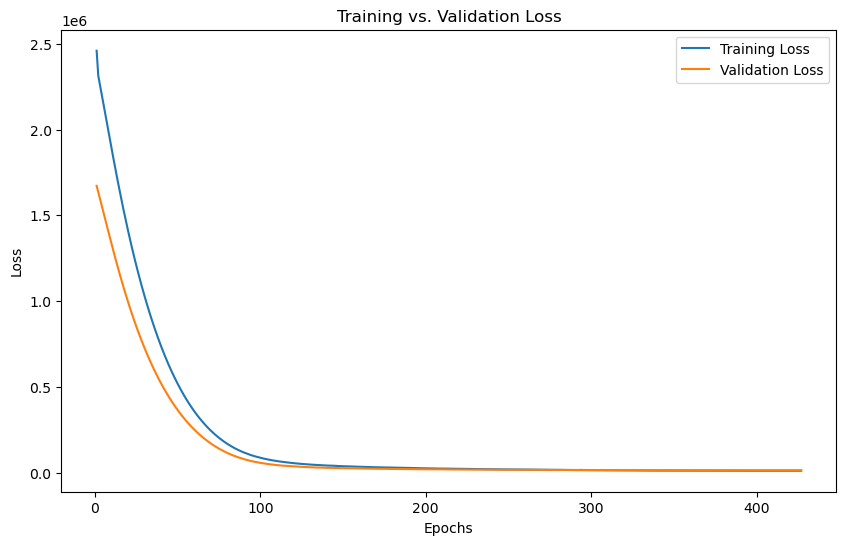

In [17]:
epochs_range = range(1, len(train_losses) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_losses, label="Training Loss")
plt.plot(epochs_range, val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.show()

The above loss cruve shows effective learning with small gap between training and validation sets. 

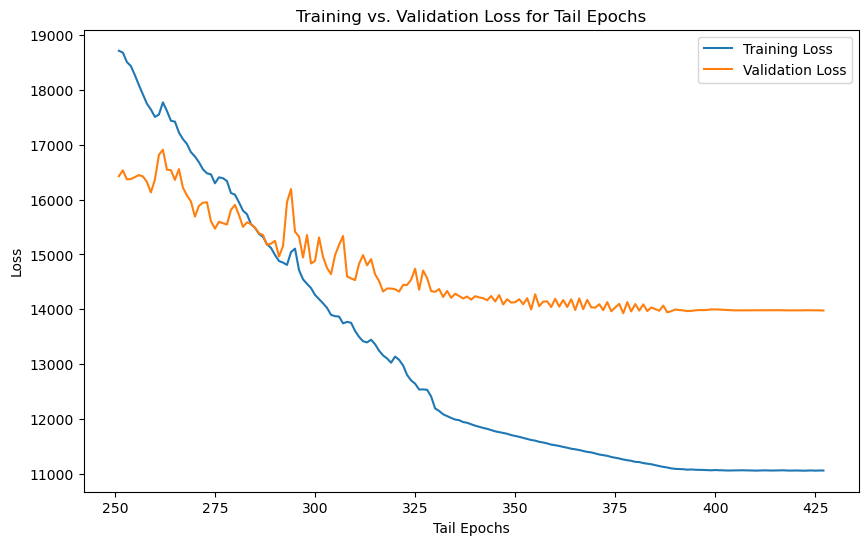

In [29]:
epochs_range = range(251, len(train_losses) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_losses[250:], label="Training Loss")
plt.plot(epochs_range, val_losses[250:], label="Validation Loss")
plt.xlabel("Tail Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss for Tail Epochs")
plt.legend()
plt.show()

The tail end of epoches shows that model is starting to overfit, so the training was stopped. 

# Model Evaluation  

For model evaluation, I have used MSE (mean squared error), MAE (mean absolute error), and R^2 score. Among these, the focus is primarily on R^2 score, as it best captures the nuances of this task. Since we aim to predict a vector based on another vector, and each component's prediction is important, R^2 provides a strong measure of explainability and overall model performance.  

In [32]:
def evaluate_model(model, test_loader, target_columns):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            all_preds.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
    
    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_targets)
    
    results = []
    for i, gene in enumerate(target_columns):
        mse = mean_squared_error(y_true[:, i], y_pred[:, i])
        mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
        r2 = r2_score(y_true[:, i], y_pred[:, i])
        results.append({
            'Gene': gene,
            'MSE': mse,
            'MAE': mae,
            'R2': r2
        })
    
    return y_true, y_pred, pd.DataFrame(results)

Here I have loaded the best model based on validation loss during training.

In [33]:
best_model = MultiOmicsTransformer(input_df.shape[1], target_df.shape[1], d_model=2048, nhead=4, num_transformer_layers=2, dropout=0.2)
best_model.load_state_dict(torch.load('best_model.pth', weights_only=True))
best_model.to("cpu")
best_model.eval()

MultiOmicsTransformer(
  (input_projection): Linear(in_features=39111, out_features=16384, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=2048, out_features=2048, bias=True)
        )
        (linear1): Linear(in_features=2048, out_features=2048, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=2048, out_features=2048, bias=True)
        (norm1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
        (activation): GELU(approximate='none')
      )
    )
    (norm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
  )
  (head): Sequential(
    (0): Linear(in_features=16384, ou

In [34]:
targets, predictions, gene_metrics = evaluate_model(best_model, test_loader, target_df.columns)

In [35]:
print(f"Test MSE: {gene_metrics['MSE'].mean():.4f}")
print(f"Test MAE: {gene_metrics['MAE'].mean():.4f}")
print(f"Test R^2: {gene_metrics['R2'].mean():.4f}")

Test MSE: 0.1582
Test MAE: 0.2948
Test R^2: 0.5795


While the mean MSE and MAE are low, the R^2 score is around 60%, indicating that some genes have not been predicted well. This suggests that certain components of the target vector are not being captured effectively by the model, potentially due to data complexity, feature limitations, or model constraints. 

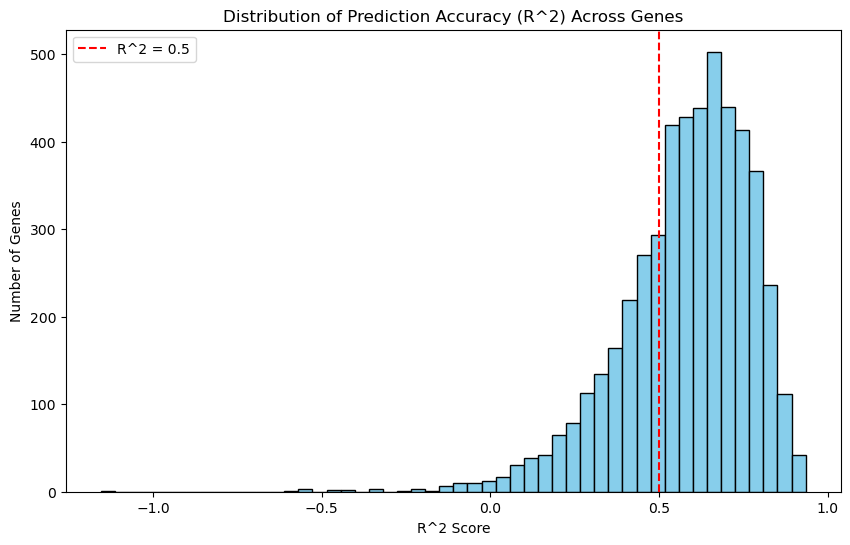

In [36]:
plt.figure(figsize=(10, 6))
plt.hist(gene_metrics['R2'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('R^2 Score')
plt.ylabel('Number of Genes')
plt.title('Distribution of Prediction Accuracy (R^2) Across Genes')
plt.axvline(x=0.5, color='red', linestyle='--', label='R^2 = 0.5')
plt.legend()
plt.show()

The above plot indicates the presence of hard-to-predict genes that are lowering the overall R^2 score. These genes contribute to higher variance in prediction errors, affecting the model's overall performance.  


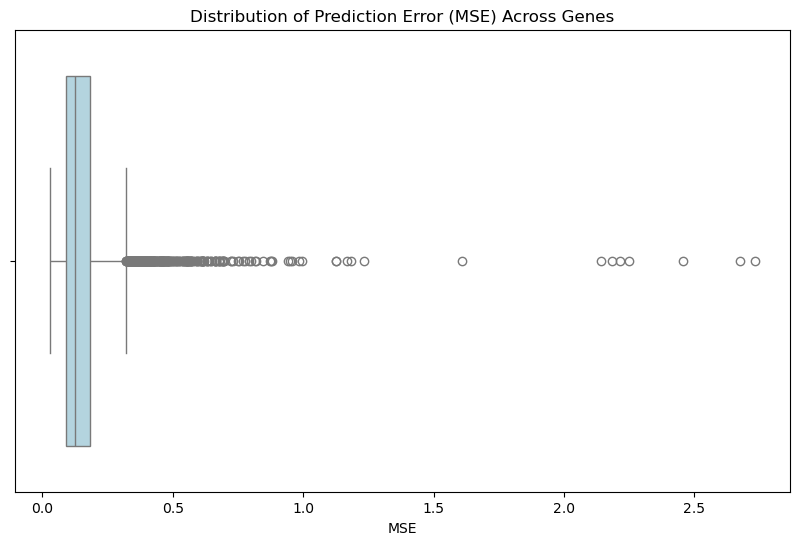

In [37]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=gene_metrics, x='MSE', orient='h', color='lightblue')
plt.xlabel('MSE')
plt.title('Distribution of Prediction Error (MSE) Across Genes')
plt.show()

The plot also reveals several outliers that contribute to higher MSE, impacting the overall evaluation metrics and indicating variability in prediction performance.  

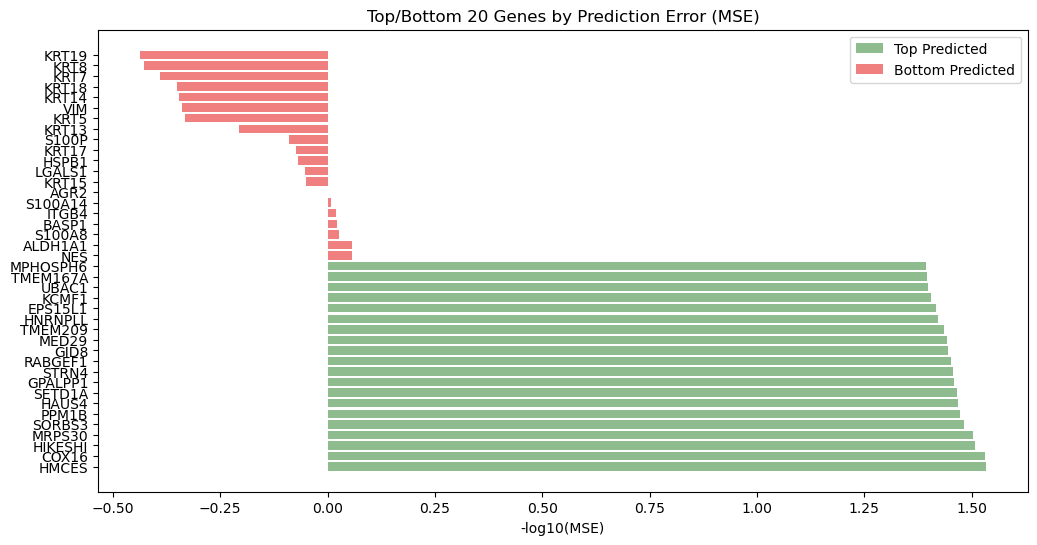

In [38]:
top_20 = gene_metrics.nsmallest(20, 'MSE').sort_values(by='MSE', ascending=True)
bottom_20 = gene_metrics.nlargest(20, 'MSE').sort_values(by='MSE', ascending=True)

fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(top_20['Gene'], -np.log10(top_20['MSE']), color='darkseagreen', label='Top Predicted')
ax.barh(bottom_20['Gene'], -np.log10(bottom_20['MSE']), color='lightcoral', label='Bottom Predicted')
ax.set_xlabel('-log10(MSE)')
ax.set_title('Top/Bottom 20 Genes by Prediction Error (MSE)')
ax.legend()
plt.show()

Overall, the best-predicted genes have low MSE, which is encouraging as it signifies that the transformer architecture effectively distills multi-omics data into proteomics data.  

In [39]:
gene_performance_sorted = gene_metrics.sort_values(
    by=["R2", "MSE"], 
    ascending=[False, True]
)
print("Top 10 Genes (High R^2 + Low MSE):")
display(gene_performance_sorted.head(10))

Top 10 Genes (High R^2 + Low MSE):


,Gene,MSE,MAE,R2
1555,GDI1,0.171057,0.356006,0.934111
2992,PDXP,0.115894,0.229177,0.933634
3240,PPP5C,0.110725,0.272243,0.933502
3095,PLEC,0.440512,0.553326,0.931169
3911,SGTA,0.159347,0.326162,0.923128
4073,SORBS3,0.032928,0.148738,0.919732
4210,STXBP1,0.159016,0.323802,0.917849
900,CRMP1,0.233055,0.379149,0.916524
1300,ENOPH1,0.054104,0.180660,0.916142
1965,IRGQ,0.101384,0.242811,0.913606


Here, I present the top 10 genes that exhibit a combination of the best R^2 and MSE scores. The results show that a gene does not necessarily need to have both the best R^2 and MSE. This is expected, as gene proteins naturally have variance that a single metric may not fully capture. Therefore, it is recommended to consider both R^2 and MSE, along with other potential metrics, to accurately determine which genes are best predicted.  

In [40]:
def plot_gene_predictions(gene_name):
    gene_idx = target_df.columns.get_loc(gene_name)
    plt.figure(figsize=(8, 6))
    plt.scatter(targets[:, gene_idx], predictions[:, gene_idx], alpha=0.6)
    plt.plot([targets.min(), targets.max()], [targets.min(), targets.max()], 'r--')
    plt.xlabel('True Expression')
    plt.ylabel('Predicted Expression')
    plt.title(f'Gene: {gene_name}\nMSE={gene_metrics[gene_metrics["Gene"] == gene_name]["MSE"].values[0]:.3f}, R^2={gene_metrics[gene_metrics["Gene"] == gene_name]["R2"].values[0]:.3f}')
    plt.show()

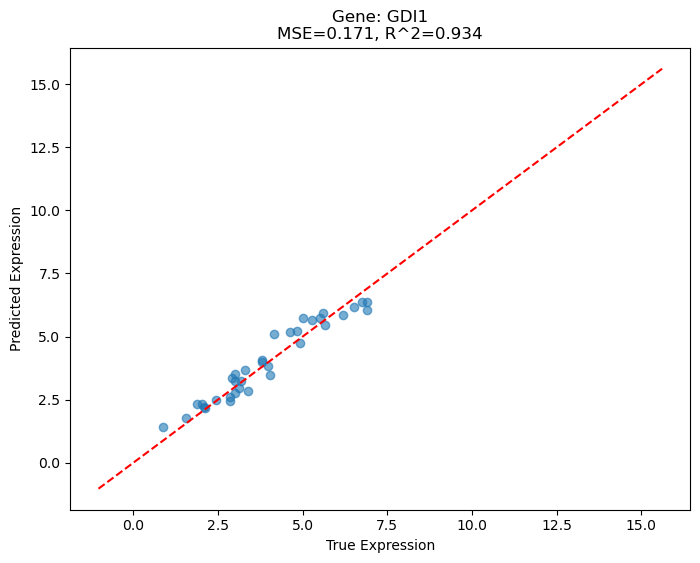

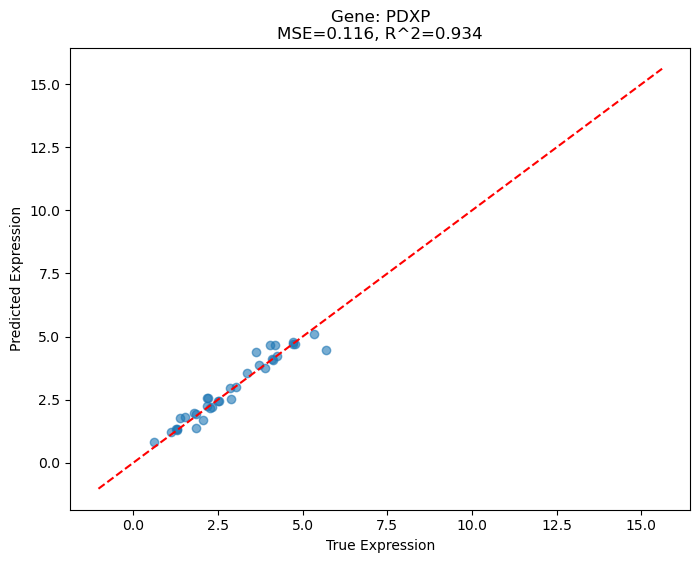

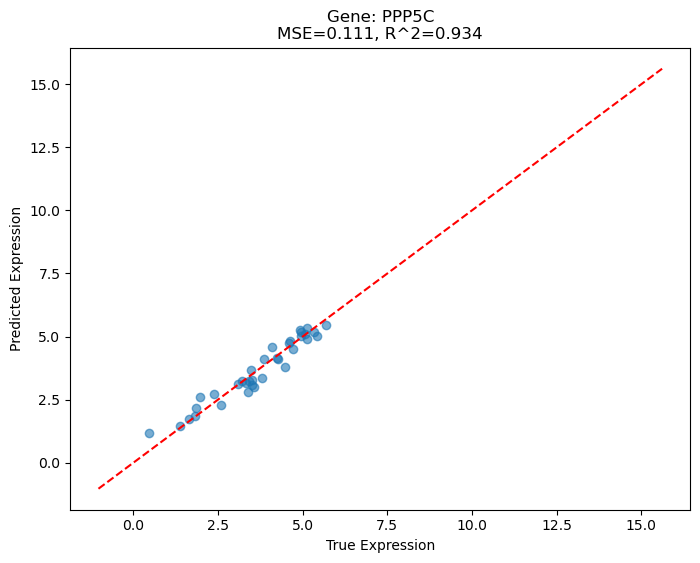

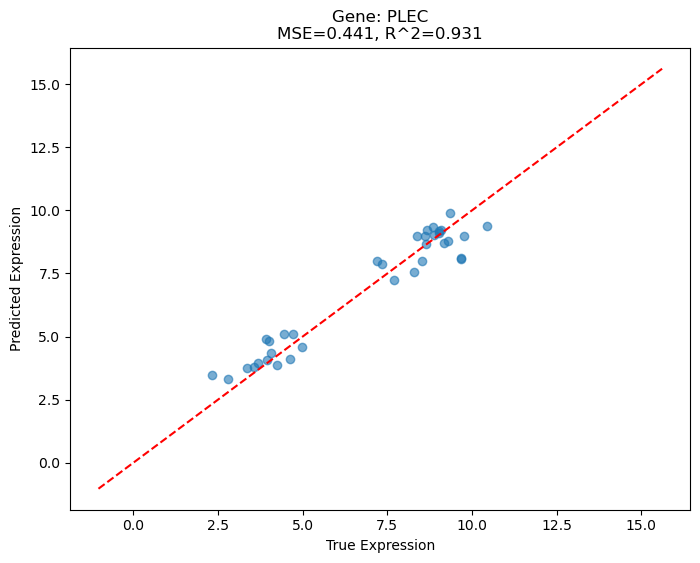

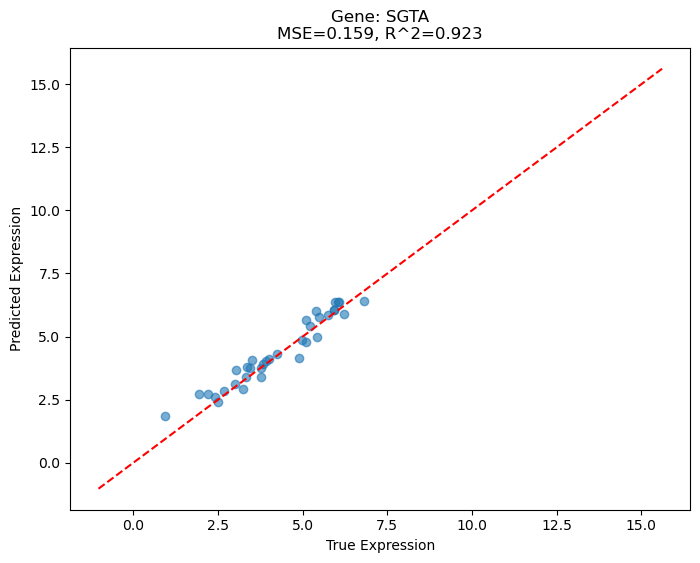

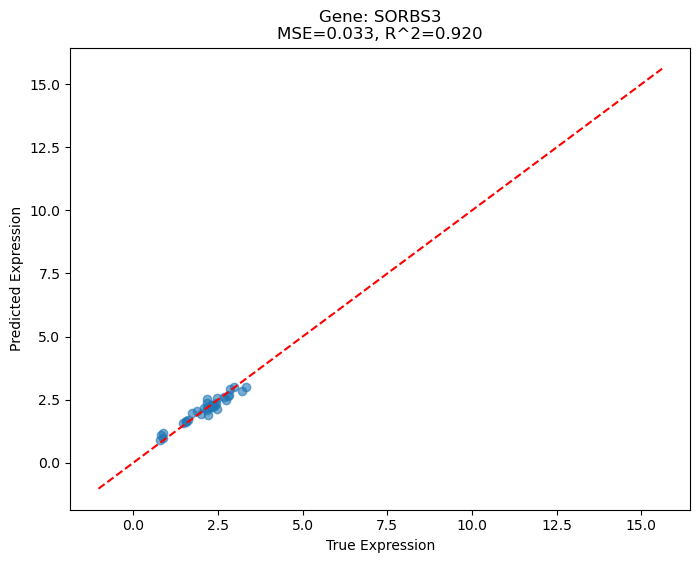

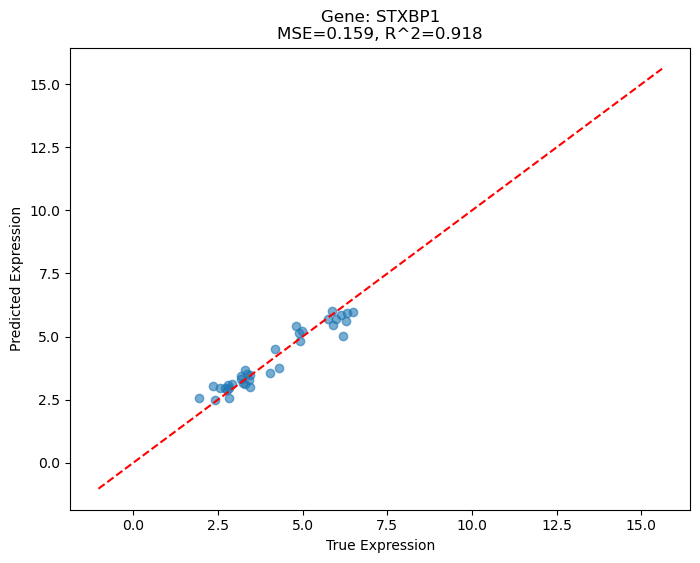

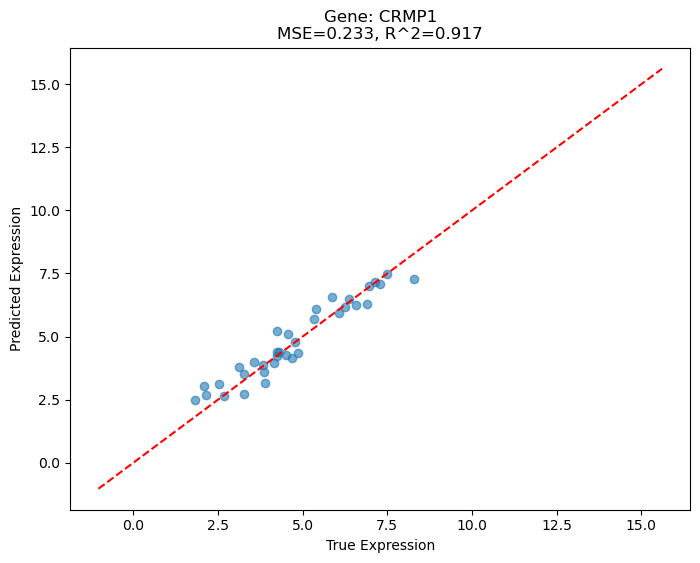

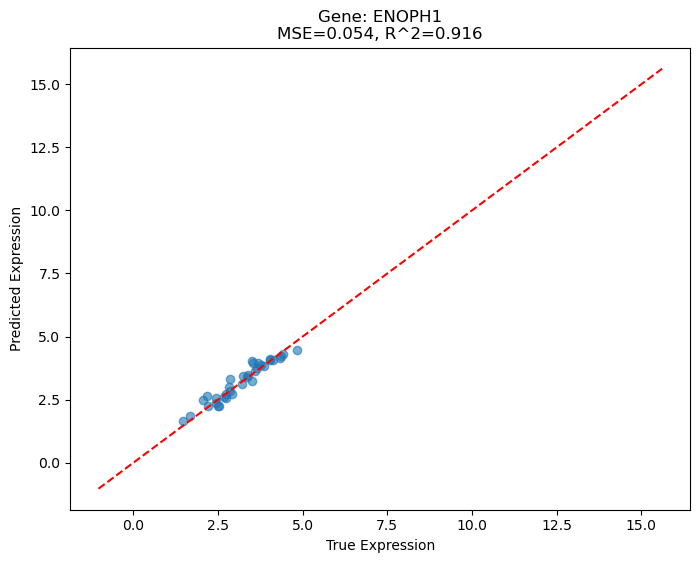

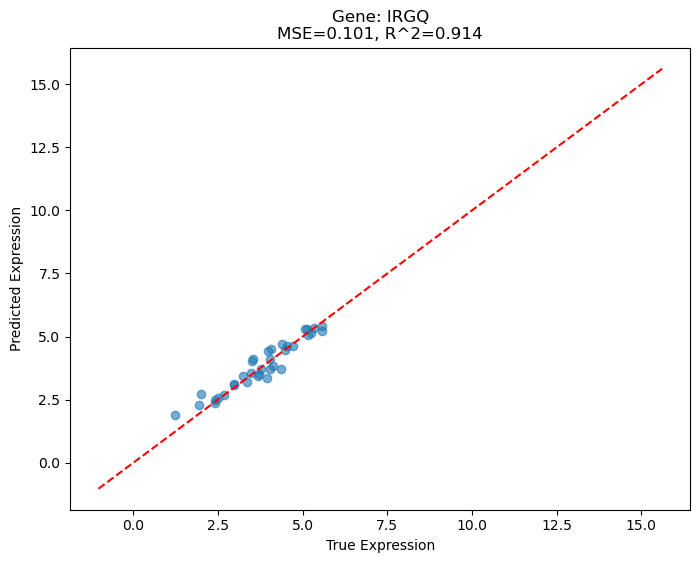

In [44]:
for gene in gene_performance_sorted.head(10)['Gene'].tolist():
    plot_gene_predictions(gene) 

The above plots show that the best-predicted genes align closely with the 45-degree line when plotting predicted vs. true values, indicating strong agreement between predictions and actual values.  

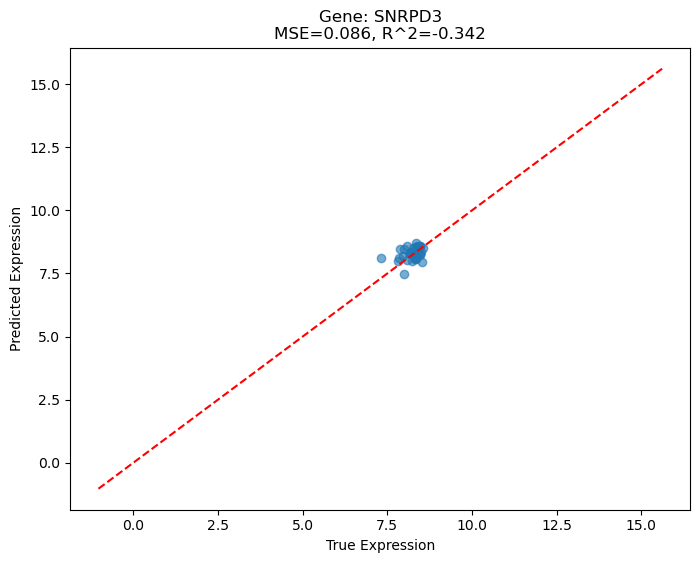

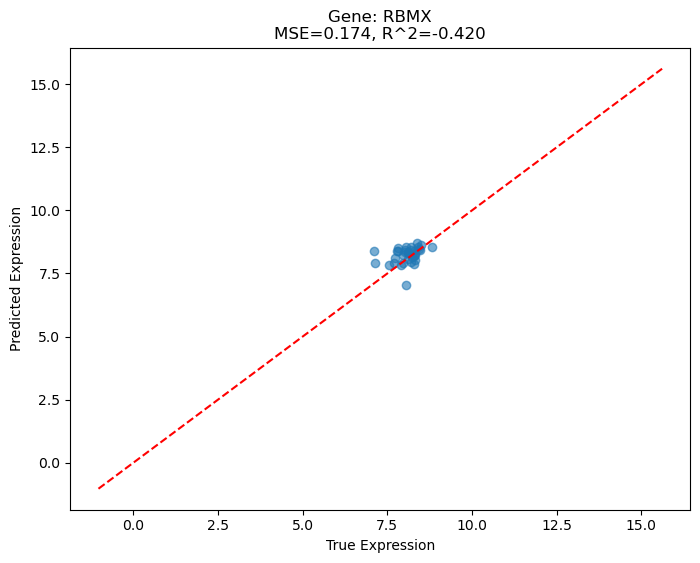

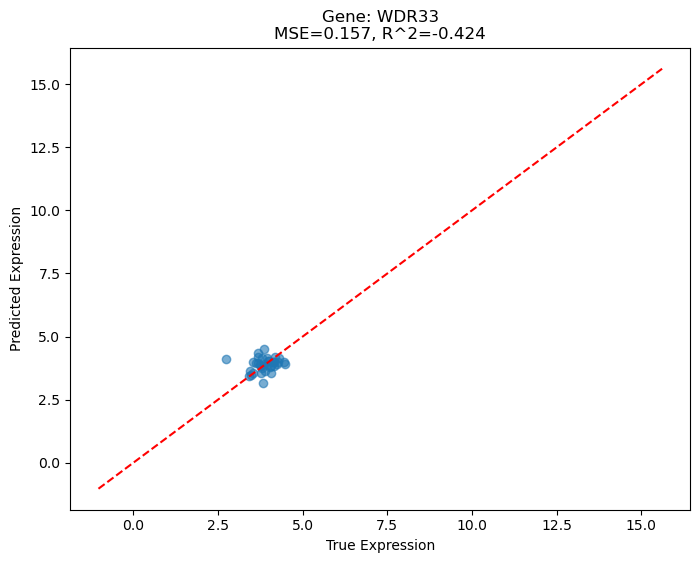

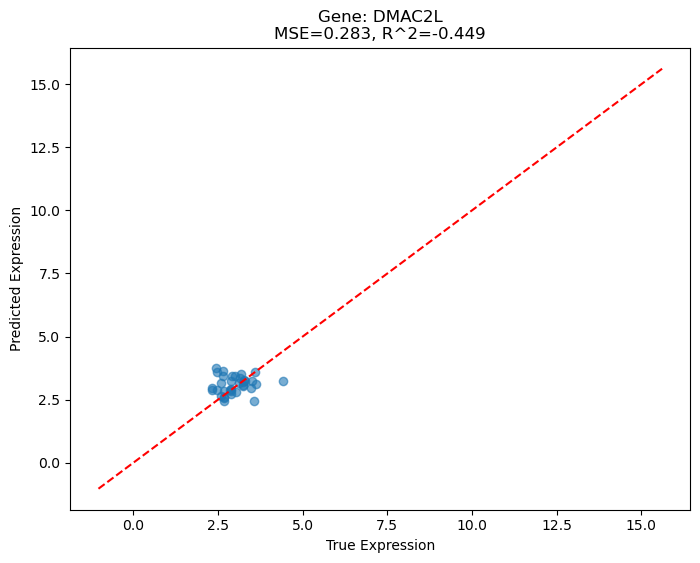

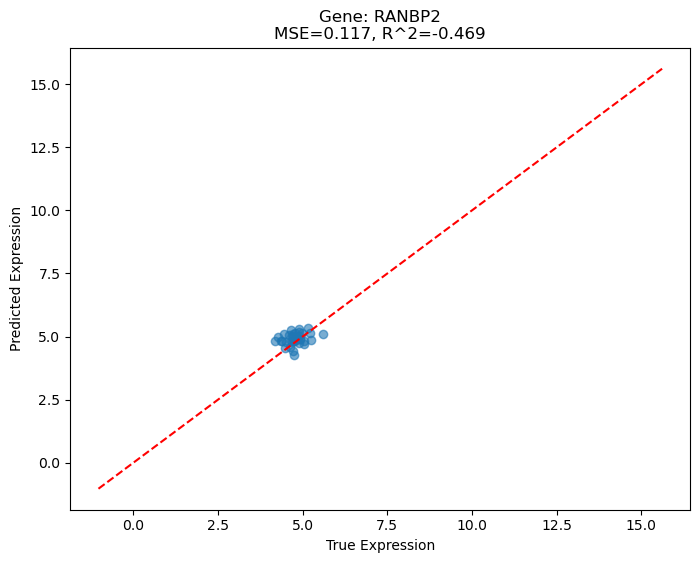

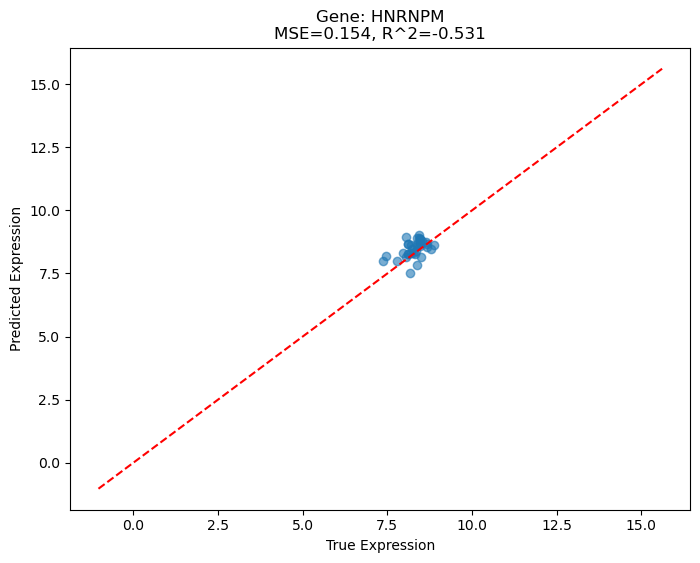

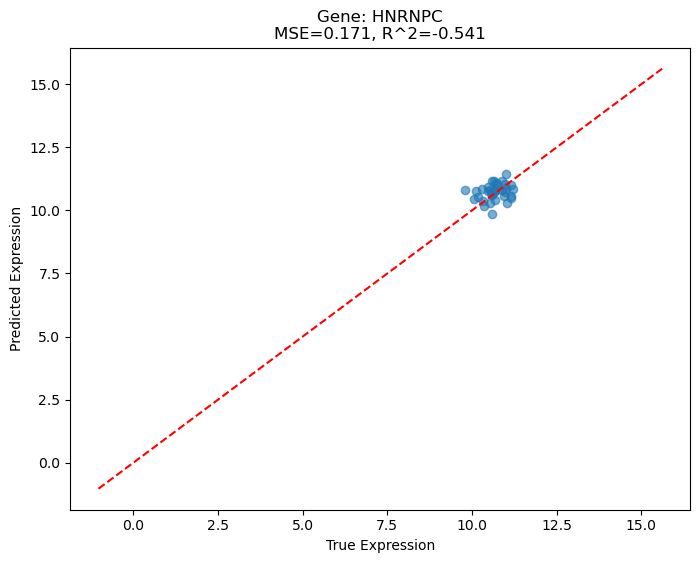

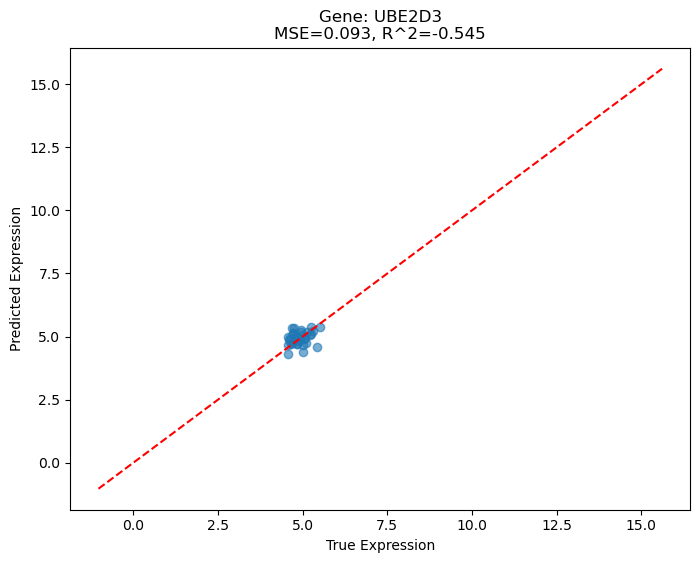

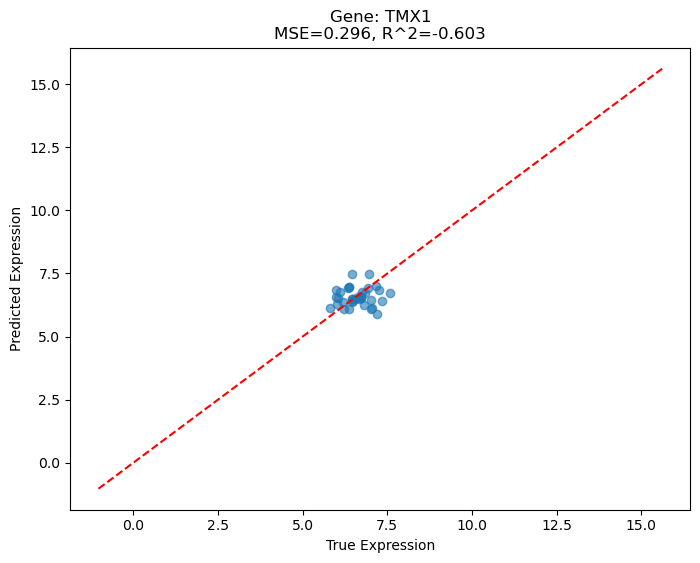

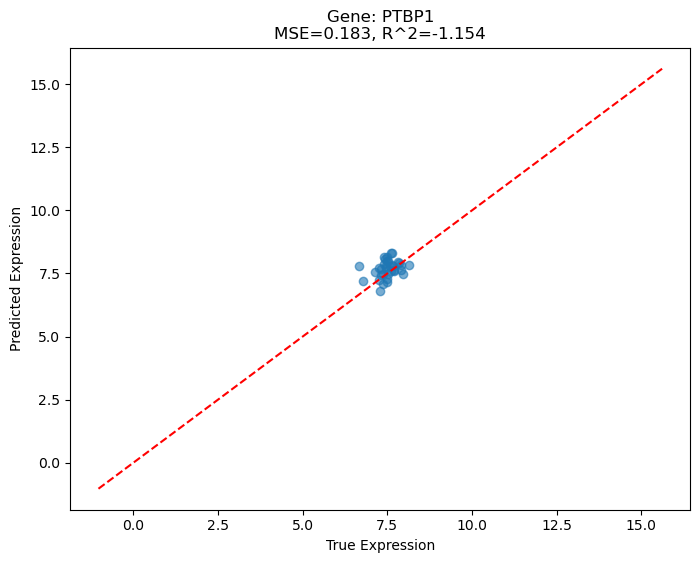

In [45]:
for gene in gene_performance_sorted.tail(10)['Gene'].tolist():
    plot_gene_predictions(gene)  

Whereas the worst-predicted genes tend to cluster in a specific region of the 45-degree line, suggesting systematic bias or challenges in capturing their variance accurately.  

**Hypothesis**: The best-predicted genes tend to have low variance, whereas the worst-predicted genes exhibit high variance, making them more challenging to model accurately.  

In [53]:
np.var(target_df[gene_performance_sorted.head(10)['Gene']], axis=0)

GDI1      2.191213
PDXP      1.550457
PPP5C     1.447532
PLEC      5.396553
SGTA      1.772341
SORBS3    0.406118
STXBP1    1.858950
CRMP1     2.727657
ENOPH1    0.621916
IRGQ      1.123916
dtype: float64

In [54]:
np.var(target_df[gene_performance_sorted.tail(10)['Gene']], axis=0)

SNRPD3    0.060340
RBMX      0.148326
WDR33     0.133429
DMAC2L    0.286954
RANBP2    0.065593
HNRNPM    0.114691
HNRNPC    0.137894
UBE2D3    0.076345
TMX1      0.264552
PTBP1     0.114617
dtype: float64

The basic analysis shows the exact opposite of my hypothesis. Possible reasons for this could be:  

- With higher variance in the training data, transformers might be capturing gene expression more effectively.  
- Genes with lower variance could be outliers in the target data, requiring a better criterion strategy for improved learning.  


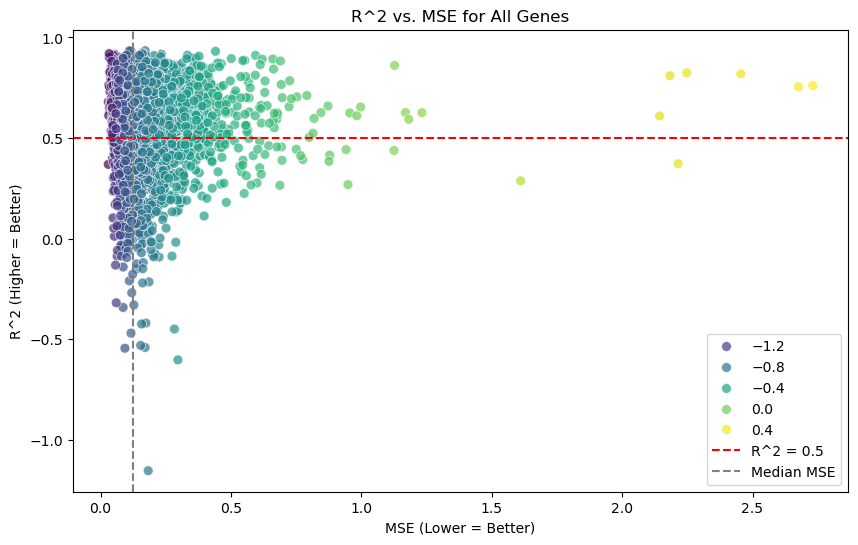

In [55]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=gene_metrics,
    x="MSE",
    y="R2",
    hue=np.log10(gene_metrics["MSE"]),  
    palette="viridis",
    alpha=0.7,
    s=50
)
plt.axhline(y=0.5, color="red", linestyle="--", label="R^2 = 0.5")  
plt.axvline(x=np.median(gene_metrics["MSE"]), color="grey", linestyle="--", label="Median MSE")
plt.xlabel("MSE (Lower = Better)")
plt.ylabel("R^2 (Higher = Better)")
plt.title("R^2 vs. MSE for All Genes")
plt.legend()
plt.show()

The above plot shows the overall prediction MSE and R^2 of the testing dataset. Most genes fall on the right-hand side of the median MSE, which is expected since the loss function was the sum of MSE.  

It also highlights that:  
- Some genes are predicted very well, with both good R^2 and MSE.  
- Some genes have poor R^2 and MSE, aligning with the earlier observation of hard-to-predict genes.  
- The majority of predictions cluster around the intersection of the median MSE and an R² of 0.5, indicating a solid baseline prediction quality while leaving room for better model fitting.  


# Further Analysis/Improvements  

If more time were available for analysis, I would focus on the following steps:  

- **Experiment with loss functions**:  
  Transformer architectures are highly sensitive to the choice of loss function. A well-designed loss function, tailored to the nature of proteomics data, could significantly enhance model learning.  

- **Hyperparameter tuning**:  
  Exploring different model dimensions, number of transformer layers, and other hyperparameters could improve representation and overall performance.  

- **Better architecture**:  
  A more domain-driven architecture could yield better results. Since my understanding of biology is limited, I have primarily relied on ML principles and statistical analysis. A biology-informed model could improve key metrics significantly.  

- **Model interpretation**:  
  Prediction alone is not enough, understanding *why* the model makes certain predictions is crucial. Analyzing transformer weights could reveal important molecular interactions at the cellular level, aiding in cancer research and other biological studies.  

- **Comparisons with other architectures**:  
  Comparing transformer-based models with alternatives like Variational Autoencoders (VAE) or even simpler models like PCA + XGBoost could provide insights into the strengths and weaknesses of different learning methodologies for this research. 

- **Ensemble Methods**:  
  Combining multiple models (e.g., an ensemble of transformers and tree-based models) could improve robustness and capture different aspects of the data.   


# References

To understand basics of proteomics data and analysis I have gone through several resouces, most importnat one are:

- Huang L, Song M, Shen H, Hong H, Gong P, Deng HW, Zhang C. Deep Learning Methods for Omics Data Imputation. Biology (Basel). 2023 Oct 7;12(10):1313. doi: 10.3390/biology12101313. PMID: 37887023; PMCID: PMC10604785.
- Transformer-based deep learning integrates multi-omic data with cancer pathways
Zhaoxiang Cai, Rebecca C. Poulos, Adel Aref, Phillip J. Robinson, Roger R. Reddel, Qing Zhong
bioRxiv 2022.10.27.514141; doi: https://doi.org/10.1101/2022.10.27.514141
- [An introduction to multi-omic data analysis methods in biosocial research by NCME on YouTube](https://youtu.be/aKU6NreNuYs?si=-3z9TZHaB9Zvse6K)
- [Proteomics 101 by JAMA Network on YouTube](https://youtu.be/loqUmQzTt8g?si=Pn35JkIHdmJ1y7OZ)
- [Machine Learning View of Multi-Omics Data Integration by OmicsLogic on YouTube](https://www.youtube.com/watch?v=Jrz6t3fbOCw)
